In [1]:
#Import some packages to use
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from keras_applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from keras.utils import np_utils,Sequence
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler,EarlyStopping,ModelCheckpoint
%matplotlib inline

Using TensorFlow backend.


In [2]:
images_dir = 'original_dataset/'
test = 'test_WyRytb0.csv'
train_dir = 'train/'
test_dir = 'test/'
labels = 'train.csv'
sample = 'sample_submission.csv'
IMG_SIZE = 150
batch_size = 4
train_split = 0.85

In [3]:
# All the labels for the training data
y_train = pd.read_csv(labels)
y_train.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [4]:
# This will help in preparing the images for test data
y_test = pd.read_csv(test)
y_test.head()

,image_name
0,3.jpg
1,5.jpg
2,6.jpg
3,11.jpg
4,14.jpg


In [5]:
#If you already have npy file load that
#X_train = prepareImages(y_train,y_train.shape[0])
X_train = np.load('traindata.npy')

In [6]:
#X_train = X_train.reshape(X_train.shape[0],3,150,150)
#X_train = X_train.astype('float32')
X_train /=255

In [8]:
# one hot encode outputs'
y_train_label = np_utils.to_categorical(y_train['label'])
num_classes = y_train_label.shape[1]
num_classes

6

In [7]:
# fix random seed for reproducibility
random_seed = 7
np.random.seed(random_seed)

In [10]:
# Split in Training set and Validation set
x_train2, x_val, y_train2, y_val = train_test_split(X_train, y_train_label, test_size = 0.15, random_state=random_seed)
print (x_train2.shape, y_train2.shape, x_val.shape, y_val.shape)

(14478, 150, 150, 3) (14478, 6) (2556, 150, 150, 3) (2556, 6)


In [9]:
## Data Augmentation
# With data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        )  # randomly flip simages


datagen.fit(X_train)

## Label Check
Check the distribution of labels in training and validation dataset

In [11]:
#Here we have {'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }
def label_display(list_label):
    real_label = ['buildings','forest','glacier','mountain','sea','street']
    freq = [0,0,0,0,0,0]
    for i in range(len(list_label)):
        j = np.argmax(list_label[i],axis=0)
        freq[j] = freq[j] + 1
    plt.bar(real_label,freq)
    #plt.xticks(real_label,frequency)
    plt.ylabel('Number of example')
    plt.title('Distribution of label in paased data')
    plt.show()

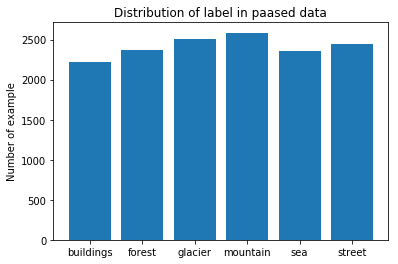

In [12]:
label_display(y_train2)

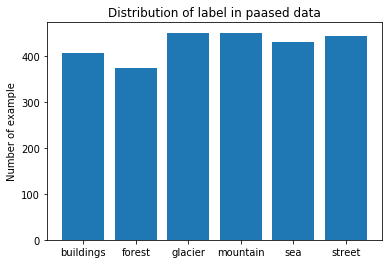

In [13]:
label_display(y_val)

## Model Formation

In [48]:
## Loading our trained weights
conv_base = applications.VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False,input_shape=(150,150,3))
#conv_base = applications.VGG16(weights=None,include_top=False,input_shape=(150,150,3))

In [49]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [50]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
print('Number of trainable weights before freezing the conv base:', len(conv_base.trainable_weights))
for layer in conv_base.layers[:5]:
    layer.trainable = False
print('Number of trainable weights after freezing the conv base:', len(conv_base.trainable_weights))
# Check the trainable status of the individual layers
for layer in conv_base.layers:
    print(layer, layer.trainable)

Number of trainable weights before freezing the conv base: 26
Number of trainable weights after freezing the conv base: 20
<keras.engine.input_layer.InputLayer object at 0x0000019F23ACD2B0> False
<keras.layers.convolutional.Conv2D object at 0x0000019F239DFFD0> False
<keras.layers.convolutional.Conv2D object at 0x0000019F2A440B00> False
<keras.layers.pooling.MaxPooling2D object at 0x000001A37D702E48> False
<keras.layers.convolutional.Conv2D object at 0x000001A37D702C50> False
<keras.layers.convolutional.Conv2D object at 0x000001A37D75FFD0> True
<keras.layers.pooling.MaxPooling2D object at 0x000001A37D785E80> True
<keras.layers.convolutional.Conv2D object at 0x000001A37D785128> True
<keras.layers.convolutional.Conv2D object at 0x000001A37D7C10F0> True
<keras.layers.convolutional.Conv2D object at 0x000001A37D7D78D0> True
<keras.layers.pooling.MaxPooling2D object at 0x000001A37D7F5E80> True
<keras.layers.convolutional.Conv2D object at 0x000001A37D7F5F98> True
<keras.layers.convolutional.Co

In [27]:
from keras import layers
from keras import models

In [28]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(6, activation='sigmoid')) 

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 6150      
Total para

In [30]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['acc'])

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    
# descriptive weight file naming
checkpointer = ModelCheckpoint(filepath=('vgg16_tf_last5conv.h5'), 
                               verbose=1, save_best_only=True)

callbacks = [early_stopping,checkpointer]

In [32]:
batch_size = 8
steps_per_epoch = x_train2.shape[0]//batch_size
validation_steps = x_val.shape[0]//batch_size

In [33]:
hist = model.fit_generator(datagen.flow(x_train2,y_train2,batch_size=batch_size),
    validation_data = (x_val,y_val),            
    validation_steps = validation_steps,
    epochs=50,
    verbose=1,
    steps_per_epoch = steps_per_epoch,
    callbacks=callbacks
)

Epoch 1/50
1809/1809 [==============================] - 399s 221ms/step - loss: 0.1506 - acc: 0.9414 - val_loss: 0.0977 - val_acc: 0.9643

Epoch 00001: val_loss improved from inf to 0.09771, saving model to vgg16_tf_last5conv.h5
Epoch 2/50
1809/1809 [==============================] - 373s 206ms/step - loss: 0.0871 - acc: 0.9684 - val_loss: 0.0936 - val_acc: 0.9638

Epoch 00002: val_loss improved from 0.09771 to 0.09363, saving model to vgg16_tf_last5conv.h5
Epoch 3/50
1809/1809 [==============================] - 369s 204ms/step - loss: 0.0727 - acc: 0.9730 - val_loss: 0.1134 - val_acc: 0.9616

Epoch 00003: val_loss did not improve from 0.09363
Epoch 4/50
1809/1809 [==============================] - 372s 206ms/step - loss: 0.0619 - acc: 0.9774 - val_loss: 0.0825 - val_acc: 0.9721

Epoch 00004: val_loss improved from 0.09363 to 0.08248, saving model to vgg16_tf_last5conv.h5
Epoch 5/50
1809/1809 [==============================] - 372s 205ms/step - loss: 0.0518 - acc: 0.9805 - val_loss: 0.

In [34]:
#Save the model
#model.load_weights('vgg16_tf.h5')

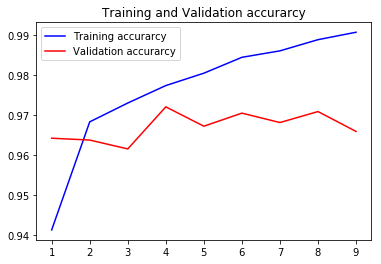

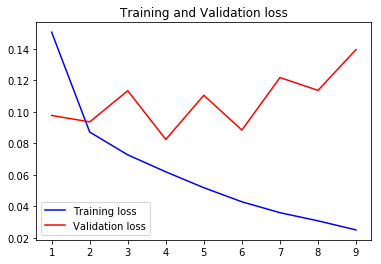

In [35]:
#get the details form the history object
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [43]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, labels):
    '''
    Plot confusion matrix of the specified accuracies and labels
    '''
    normalize = True
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    
    # Draw ticks
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    
    # Normalize
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

In [37]:
score = model.evaluate(x_val,y_val,batch_size=8)
print(score)

2556/2556 [==============================] - 31s 12ms/step
[0.1395571469383885, 0.9659624554928107]


In [38]:
predict_val = model.predict(x_val,batch_size=8,verbose=1)

2556/2556 [==============================] - 30s 12ms/step


In [39]:
prediction_val_list = np.argmax(predict_val,axis=1)
actual_label = np.argmax(y_val,axis=1)

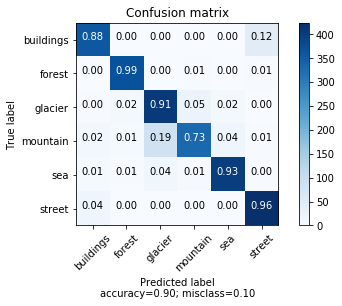

In [44]:
real_label = ['buildings','forest','glacier','mountain','sea','street']
val_cm = confusion_matrix(actual_label,prediction_val_list)
plot_confusion_matrix(val_cm,real_label)

## Predictions
Test set is save in test npy file with 150,150,3 dimension

In [33]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
def prepareTest(data, m):
    print("Preparing images")
    X_train = np.zeros((m, 150, 150, 3))
    count = 0
    
    for fig in data['image_name']:
        #load images into images of size 150*150(original size)
        #src = cv2.imread("train/"+fig,)
        #img = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
        img = image.load_img("original_dataset/"+fig, target_size=(150, 150, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_train[count] = x
        count += 1
        if(count%1000==0):
            print('images done :',count)
    np.save('test.npy',X_train)
    return X_train

In [45]:
#x_test = prepareTest(y_test,y_test.shape[0])
x_test = np.load('test.npy')
x_test /= 255

In [46]:
result = np.zeros((x_test.shape[0],6))
result = model.predict(x_test,batch_size=8,verbose=1)
result = np.argmax(result,axis=1)
results = pd.Series(result,name='label')

7301/7301 [==============================] - 91s 12ms/step


In [47]:
y_test['label'] = results
y_test.to_csv('vgg_16_tf_last5conv.csv',index=False)